In [3]:
import torch
import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
import numpy as np
import random

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

##################################################################
# TODO: Create hyperparameter argument class
# Use image size of 64x64 in Q1. We will use a default size of
# 224x224 for the rest of the questions.
# You should experiment and choose the correct hyperparameters
# You should get a map of around 22 in 5 epochs
##################################################################
args = ARGS(
    epochs=5,
    inp_size=64,
    use_cuda=True,
    val_every=70,
    lr= 1e-3, 
    batch_size= 32,
    step_size= 2, 
    gamma= 0.87,
    )
##################################################################
#                          END OF YOUR CODE                      #
##################################################################

print(args)

# initializes the model
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
# initializes Adam optimizer and simple StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
# trains model using your training code and reports test map
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)


args.batch_size = 32
args.device = cuda
args.epochs = 5
args.gamma = 0.87
args.inp_size = 64
args.log_every = 100
args.lr = 0.001
args.save_at_end = False
args.save_freq = -1
args.step_size = 2
args.test_batch_size = 1000
args.val_every = 70

Train Epoch: 0 [0 (0%)]	Loss: 0.694501
map:  0.08280466330905135
map:  0.15041740092815858
Train Epoch: 0 [100 (64%)]	Loss: 0.201839
map:  0.1867245604501064
Train Epoch: 1 [200 (27%)]	Loss: 0.175778
map:  0.19941988091064236
map:  0.21985056923779842
Train Epoch: 1 [300 (91%)]	Loss: 0.152669
map:  0.2101807447108422
Train Epoch: 2 [400 (55%)]	Loss: 0.186508
map:  0.22792753896876417
map:  0.22872393041894107
Train Epoch: 3 [500 (18%)]	Loss: 0.166465
map:  0.22660402130369892
Train Epoch: 3 [600 (82%)]	Loss: 0.192111
map:  0.23105571070457617
Train Epoch: 4 [700 (46%)]	Loss: 0.125591
map:  0.2240769163820887
map:  0.22125296252244894
test map: 0.2205755809704628


Feature matrix: (1000, 512)
Labels matrix: (1000, 20)


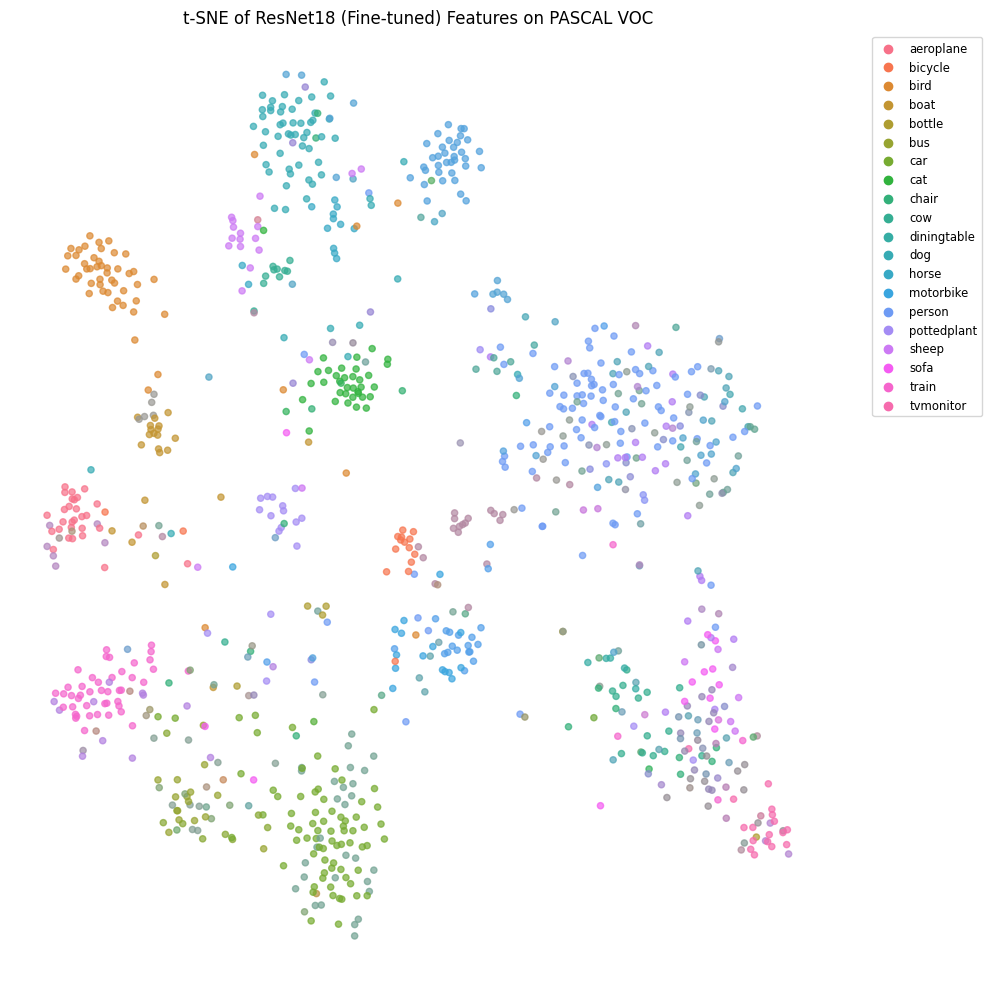

In [6]:
import torch
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from voc_dataset import VOCDataset
from torch.utils.data import DataLoader
import torchvision.models as models
import seaborn as sns
from matplotlib.colors import to_rgb

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 20)

    def forward(self, x):
        return self.resnet(x)

model = MyModel()
model.load_state_dict(torch.load("checkpoint-model-epoch50.pth", map_location="cuda"))
model.eval().cuda()


# 2️⃣ Remove the final classification layer so we get features before logits
# (assuming you defined model.resnet.fc)
feature_extractor = torch.nn.Sequential(*list(model.resnet.children())[:-1])  # outputs [N,512,1,1]
feature_extractor.eval().cuda()

# 3️⃣ Load test data
test_dataset = VOCDataset(split='test', size=224)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 4️⃣ Randomly sample 1000 images
indices = random.sample(range(len(test_dataset)), 1000)
subset = torch.utils.data.Subset(test_dataset, indices)
subset_loader = DataLoader(subset, batch_size=32, shuffle=False)

# 5️⃣ Extract features and labels
features, labels = [], []
with torch.no_grad():
    for imgs, labs, _ in subset_loader:
        imgs = imgs.cuda()
        feats = feature_extractor(imgs).squeeze(-1).squeeze(-1)  # shape [B,512]
        features.append(feats.cpu().numpy())
        labels.append(labs.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)  # shape [1000,20] binary multi-labels

print("Feature matrix:", features.shape)
print("Labels matrix:", labels.shape)

# 6️⃣ Compute t-SNE projection (sklearn)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
tsne_feats = tsne.fit_transform(features)

# 7️⃣ Assign a unique color per class
CLASS_NAMES = VOCDataset.CLASS_NAMES
palette = sns.color_palette("husl", len(CLASS_NAMES))
class_colors = np.array([to_rgb(c) for c in palette])  # (20,3)

# 8️⃣ Compute mixed color for each image if multi-label
mixed_colors = []
for lab_vec in labels:
    active = np.where(lab_vec > 0)[0]
    if len(active) == 0:
        mixed_colors.append((0.5, 0.5, 0.5))  # gray if no label (unlikely)
    else:
        mean_color = class_colors[active].mean(axis=0)
        mixed_colors.append(mean_color)

mixed_colors = np.array(mixed_colors)

# 9️⃣ Plot t-SNE
plt.figure(figsize=(10, 10))
plt.scatter(tsne_feats[:, 0], tsne_feats[:, 1], c=mixed_colors, s=20, alpha=0.7)
plt.title("t-SNE of ResNet18 (Fine-tuned) Features on PASCAL VOC")
plt.axis('off')

#  🔟 Add legend
for name, color in zip(CLASS_NAMES, palette):
    plt.scatter([], [], color=color, label=name)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

